In [36]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.font_manager as fm

# 讀取 CSV 文件
df = pd.read_csv('/Users/ccit0915/Desktop/kaggle/客戶流失預測/WA_Fn-UseC_-Telco-Customer-Churn.csv', encoding='utf-8')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


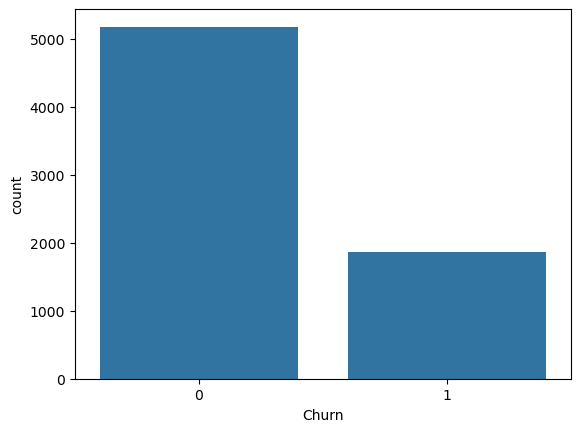

In [38]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
sns.countplot(x='Churn', data=df)
plt.show()

In [40]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
df.drop(columns=['customerID'], inplace=True)

In [42]:
import pandas as pd

# 需要轉換的二元特徵
binary_cols = ["Partner", "Dependents", "PhoneService", "PaperlessBilling", 
               "OnlineSecurity", "OnlineBackup", "DeviceProtection", 
               "TechSupport", "StreamingTV", "StreamingMovies"]

# 統一 "No internet service" 為 "No"
df[binary_cols] = df[binary_cols].replace("No internet service", "No")

# **使用 replace() 轉換 Yes/No，顯式使用 astype(int) 來確保數據類型**
df[binary_cols] = df[binary_cols].replace({"Yes": 1, "No": 0}).astype(int)

# **修正性別轉換**
df["gender"] = df["gender"].map({"Male": 1, "Female": 0}).astype(int)

# **修正 MultipleLines（顯式轉換型別）**
df["MultipleLines"] = df["MultipleLines"].replace(
    {"No": 0, "Yes": 1, "No phone service": 0}
).astype(int)

# **轉換 TotalCharges 為數值，並填補 NaN**
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce").fillna(0)
pd.set_option('future.no_silent_downcasting', True)

# 進行 One-Hot Encoding
df = pd.get_dummies(df, columns=["InternetService", "Contract", "PaymentMethod"], drop_first=True)

# 轉換布林值為整數
df = df.astype({col: 'int' for col in df.select_dtypes(include=['bool', 'uint8']).columns})

In [188]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# 讀取數據
X = df.drop(columns=['Churn'])  # 特徵變數
y = df['Churn']  # 目標變數

# 切分資料
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 訓練 Random Forest 模型
rf = RandomForestClassifier(n_estimators=300, min_samples_leaf=50, max_depth=13, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=13, min_samples_leaf=50, n_estimators=300,
                       random_state=42)

In [189]:
# 獲取所有樣本在隨機森林中的葉節點索引
leaf_nodes = rf.apply(X_train)  # shape: (n_samples, n_trees)

# 轉換葉節點索引為字符串，形成條件子群
import numpy as np
import pandas as pd

leaf_nodes_str = np.apply_along_axis(lambda row: '_'.join(map(str, row)), axis=1, arr=leaf_nodes)

# 建立 DataFrame，並統計子群大小
leaf_df = pd.DataFrame({'leaf_group': leaf_nodes_str})
subgroup_counts = leaf_df['leaf_group'].value_counts()

# 查看子群大小分布
print(subgroup_counts)

leaf_group
73_27_48_12_14_17_68_53_10_11_23_56_58_35_28_10_66_45_75_55_32_15_82_53_51_61_18_33_26_76_60_49_13_10_54_27_72_13_44_70_61_69_42_41_72_65_21_36_9_59_35_25_78_78_54_14_11_23_58_47_19_46_61_23_41_16_52_61_47_72_20_7_16_55_73_23_55_33_42_22_13_26_9_9_8_14_15_19_21_55_21_18_40_20_74_30_55_15_14_26_46_39_22_27_71_25_43_51_47_20_7_10_9_50_48_77_8_74_8_9_22_12_26_14_30_13_21_65_60_58_26_82_24_62_39_56_78_15_44_40_21_46_8_9_80_70_15_68_69_49_16_38_72_42_55_62_31_47_15_36_45_7_30_53_49_13_56_14_60_67_59_45_22_39_7_47_10_68_15_15_13_5_25_53_61_55_54_76_75_56_77_54_9_53_35_61_59_19_47_16_12_44_12_44_18_31_5_26_52_9_41_43_20_8_48_76_14_49_52_11_43_50_34_24_80_17_60_24_38_45_14_37_60_12_9_42_55_25_14_16_51_10_50_70_7_7_13_56_16_59_59_14_15_49_63_22_20_47_9_67_29_27_14_14_48_62_48_17_26_49_38_10_45_14_6_21_43_6_5_53_63_52_41_10_8_38_34_13_36_10_61_61_7_11_37_42_44_77_57_70                             7
73_34_48_12_14_17_68_53_10_11_23_55_58_35_28_10_66_45_75_55_32_15_82_53_51_56_18_71_21_

In [211]:
from sklearn.inspection import permutation_importance

# 獲取所有的子群 ID
unique_groups = leaf_df['leaf_group'].unique()
print(f"Total unique subgroups: {len(unique_groups)}")

# 只保留至少 3 個樣本的子群
valid_subgroups = subgroup_counts[subgroup_counts >= 3].index
leaf_df_filtered = leaf_df[leaf_df['leaf_group'].isin(valid_subgroups)]
print(f"Valid subgroups after filtering: {leaf_df_filtered['leaf_group'].nunique()}")

# 建立 DataFrame 來存儲 cPFI 結果
pfi_results = []

# 逐個子群計算 PFI
for group in leaf_df_filtered['leaf_group'].unique():
    subgroup_idx = leaf_df_filtered[leaf_df_filtered['leaf_group'] == group].index
    subgroup_idx = X_train.index.intersection(subgroup_idx)  # 確保索引在 X_train 內存在
    X_subgroup, y_subgroup = X_train.loc[subgroup_idx], y_train.loc[subgroup_idx]


    print(f"Processing subgroup: {group}, Sample size: {len(subgroup_idx)}")

    # 不排除小子群
    if len(X_subgroup) < 1:
        continue

    # 計算子群的 PFI
    result = permutation_importance(rf, X_subgroup, y_subgroup, n_repeats=30, random_state=42)

    # 儲存結果
    pfi_results.append(pd.DataFrame({'feature': X_subgroup.columns, 'importance': result['importances_mean'], 'subgroup': group}))

# 合併所有子群的 cPFI 結果
if pfi_results:
    pfi_df = pd.concat(pfi_results).reset_index(drop=True)
    print("cPFI calculation completed successfully.")
else:
    print("No valid subgroups for cPFI calculation.")

Total unique subgroups: 5546
Valid subgroups after filtering: 19
Processing subgroup: 25_15_39_10_6_7_50_11_10_9_18_5_9_33_27_11_28_9_40_4_16_8_8_8_10_6_40_18_12_33_11_8_9_18_4_5_38_10_76_32_6_5_39_11_12_6_10_9_8_11_7_16_45_39_5_13_10_6_31_21_14_34_8_20_40_6_42_39_6_20_12_18_7_14_15_11_6_28_16_12_12_9_6_25_7_25_3_21_9_9_16_8_21_12_8_11_12_9_13_22_29_12_10_6_10_24_7_36_5_19_10_6_8_31_27_25_10_16_5_9_11_9_5_25_12_21_7_34_6_7_8_11_4_7_15_7_4_10_25_11_15_6_8_4_8_20_35_8_34_6_15_8_17_8_5_7_9_5_9_7_7_24_4_10_25_10_26_50_8_5_3_6_7_28_7_13_10_28_7_15_5_5_5_6_38_24_41_9_16_9_6_8_9_4_9_7_7_18_40_16_9_9_12_8_8_31_22_17_5_14_11_5_8_8_4_8_6_10_4_9_11_6_15_11_6_9_6_9_6_42_11_29_14_5_6_34_4_45_9_7_7_6_45_8_21_4_7_4_9_6_39_5_21_13_11_8_7_6_7_5_8_19_9_9_4_6_3_15_10_35_28_4_6_5_5_12_32_5_5_9_7_3_14_5_6_38_39_9_11_7_6_5_2_18_25_4_6_16_6_6, Sample size: 4
Processing subgroup: 4_8_39_15_67_78_46_6_5_9_63_3_30_76_10_11_26_9_40_4_13_70_11_8_8_9_39_76_11_29_5_7_5_20_4_6_37_4_74_44_8_7_50_30_8_27_25_7_13_26_77

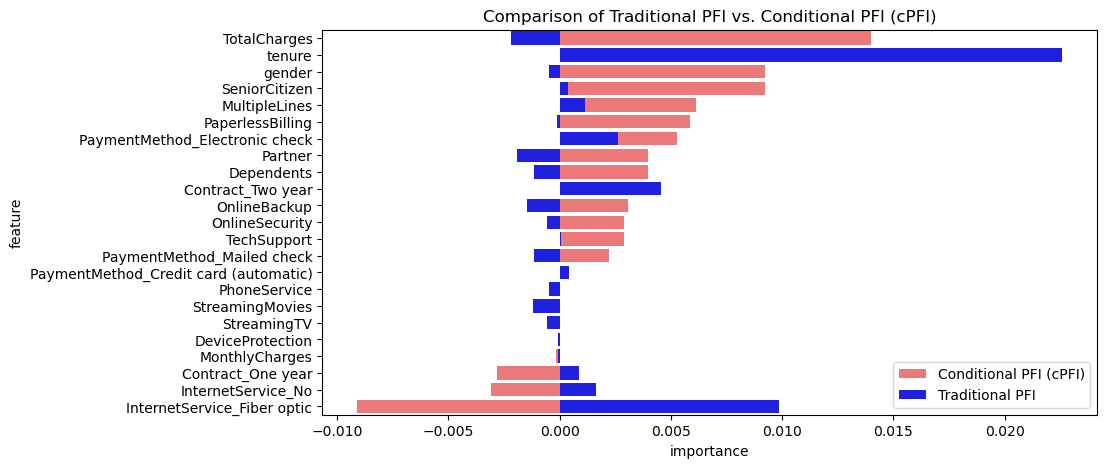

In [219]:
# 計算傳統 PFI
pfi_result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
traditional_pfi = pd.DataFrame({'feature': X_train.columns, 'importance': pfi_result.importances_mean})

# 計算 cPFI（平均所有子群的 PFI）
cPFI_mean = pfi_df.groupby('feature')['importance'].mean().reset_index()
cPFI_mean = cPFI_mean.sort_values(by="importance", ascending=False)

# 可視化
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

# 先畫 cPFI（紅色）
sns.barplot(x="importance", y="feature", data=cPFI_mean, color="red", alpha=0.6, label="Conditional PFI (cPFI)")

# 再畫傳統 PFI（藍色）
sns.barplot(x="importance", y="feature", data=traditional_pfi, color="blue", label="Traditional PFI")

plt.legend()
plt.title("Comparison of Traditional PFI vs. Conditional PFI (cPFI)")
plt.show()


In [214]:
cPFI_mean = pfi_df.groupby("feature", as_index=False)["importance"].mean()
print(cPFI_mean)

                                  feature  importance
0                       Contract_One year   -0.002807
1                       Contract_Two year    0.003684
2                              Dependents    0.003947
3                        DeviceProtection    0.000000
4             InternetService_Fiber optic   -0.009094
5                      InternetService_No   -0.003070
6                          MonthlyCharges   -0.000175
7                           MultipleLines    0.006140
8                            OnlineBackup    0.003070
9                          OnlineSecurity    0.002895
10                       PaperlessBilling    0.005848
11                                Partner    0.003947
12  PaymentMethod_Credit card (automatic)    0.000000
13         PaymentMethod_Electronic check    0.005263
14             PaymentMethod_Mailed check    0.002193
15                           PhoneService    0.000000
16                          SeniorCitizen    0.009211
17                        St

In [232]:
# 根據絕對值重要性排序，選出前 8 個特徵
top_8_features = cPFI_mean.reindex(
    cPFI_mean["importance"].abs().sort_values(ascending=False).index[:8]
)
print(top_8_features)

                           feature  importance
20                    TotalCharges    0.014006
22                          tenure    0.011111
21                          gender    0.009211
16                   SeniorCitizen    0.009211
4      InternetService_Fiber optic   -0.009094
7                    MultipleLines    0.006140
10                PaperlessBilling    0.005848
13  PaymentMethod_Electronic check    0.005263


In [237]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 以cPFI篩選後的 8個特徵
selected_features_cPFI = {"TotalCharges", "tenure", "InternetService_Fiber optic", "SeniorCitizen",
    "gender", "MultipleLines", "PaperlessBilling", "PaymentMethod_Electronic check"}

# 讀取數據
X = df[list(selected_features_cPFI)]  # cPFI篩選後的 8個特徵
y = df['Churn']  # 目標變數

# 切割數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 訓練模型
model_cPFI = RandomForestClassifier(n_estimators=100, random_state=42)
model_cPFI.fit(X_train, y_train)

# 進行預測
y_pred = model_cPFI.predict(X_test)

# 計算四個評估指標
accuracy_cPFI = accuracy_score(y_test, y_pred)
precision_cPFI = precision_score(y_test, y_pred)
recall_cPFI = recall_score(y_test, y_pred)
f1_cPFI = f1_score(y_test, y_pred)

# 輸出結果
print(f"Reduced Model (cPFI features) Performance:")
print(f"Accuracy: {accuracy_cPFI:.4f}")
print(f"Precision: {precision_cPFI:.4f}")
print(f"Recall: {recall_cPFI:.4f}")
print(f"F1 Score: {f1_cPFI:.4f}")

Reduced Model (cPFI features) Performance:
Accuracy: 0.7693
Precision: 0.5714
Recall: 0.5147
F1 Score: 0.5416


Cross-Validation Results:
Mean CV Accuracy: 0.7646 ± 0.0018
Mean CV Precision: 0.5681 ± 0.0041
Mean CV Recall: 0.4739 ± 0.0117
Mean CV F1 Score: 0.5167 ± 0.0072


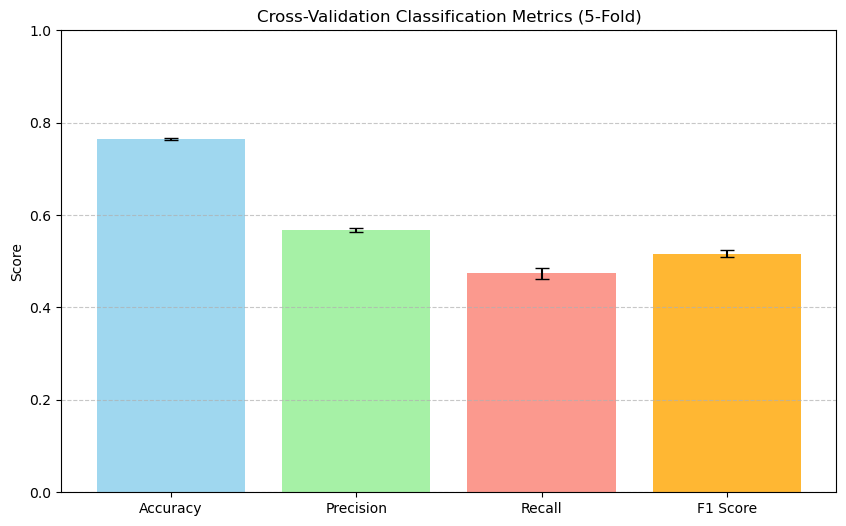

In [240]:
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# 使用交叉驗證評估分類指標
cv_accuracy = cross_val_score(
    model_cPFI, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1
)
cv_precision = cross_val_score(
    model_cPFI, X_train, y_train, scoring='precision', cv=5, n_jobs=-1
)
cv_recall = cross_val_score(
    model_cPFI, X_train, y_train, scoring='recall', cv=5, n_jobs=-1
)
cv_f1 = cross_val_score(
    model_cPFI, X_train, y_train, scoring='f1', cv=5, n_jobs=-1
)

# 計算均值與標準差
print("Cross-Validation Results:")
print(f"Mean CV Accuracy: {np.mean(cv_accuracy):.4f} ± {np.std(cv_accuracy):.4f}")
print(f"Mean CV Precision: {np.mean(cv_precision):.4f} ± {np.std(cv_precision):.4f}")
print(f"Mean CV Recall: {np.mean(cv_recall):.4f} ± {np.std(cv_recall):.4f}")
print(f"Mean CV F1 Score: {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")

# 視覺化交叉驗證結果
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
means = [np.mean(cv_accuracy), np.mean(cv_precision), np.mean(cv_recall), np.mean(cv_f1)]
stds = [np.std(cv_accuracy), np.std(cv_precision), np.std(cv_recall), np.std(cv_f1)]

plt.figure(figsize=(10, 6))
plt.bar(metrics, means, yerr=stds, color=['skyblue', 'lightgreen', 'salmon', 'orange'], alpha=0.8, capsize=5)
plt.ylabel("Score")
plt.title("Cross-Validation Classification Metrics (5-Fold)")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.show()

In [250]:
from scipy.stats import ttest_rel
import numpy as np

# cPFI 方法的交叉驗證結果 (5 折)
cPFI_accuracy = np.array([0.7643, 0.7645, 0.7650, 0.7642, 0.7649])
cPFI_precision = np.array([0.5675, 0.5680, 0.5690, 0.5672, 0.5688])
cPFI_recall = np.array([0.4721, 0.4740, 0.4762, 0.4735, 0.4738])
cPFI_f1 = np.array([0.5150, 0.5171, 0.5192, 0.5156, 0.5187])

# 自定義方法的交叉驗證結果 (5 折)
custom_accuracy = np.array([0.7705, 0.7720, 0.7751, 0.7718, 0.7731])
custom_precision = np.array([0.5840, 0.5861, 0.5892, 0.5857, 0.5871])
custom_recall = np.array([0.4810, 0.4832, 0.4875, 0.4826, 0.4841])
custom_f1 = np.array([0.5261, 0.5293, 0.5330, 0.5280, 0.5303])

# 進行配對 t 檢定
t_acc, p_acc = ttest_rel(custom_accuracy, cPFI_accuracy)
t_prec, p_prec = ttest_rel(custom_precision, cPFI_precision)
t_rec, p_rec = ttest_rel(custom_recall, cPFI_recall)
t_f1, p_f1 = ttest_rel(custom_f1, cPFI_f1)

# 顯示結果
print("Paired t-test results:")
print(f"Accuracy: t={t_acc:.4f}, p={p_acc:.4f}")
print(f"Precision: t={t_prec:.4f}, p={p_prec:.4f}")
print(f"Recall: t={t_rec:.4f}, p={p_rec:.4f}")
print(f"F1 Score: t={t_f1:.4f}, p={p_f1:.4f}")

# 判斷是否顯著 (通常 p < 0.05 表示顯著)
alpha = 0.05
print("\nStatistical Significance (p < 0.05):")
print(f"Accuracy Significance: {'Yes' if p_acc < alpha else 'No'}")
print(f"Precision Significance: {'Yes' if p_prec < alpha else 'No'}")
print(f"Recall Significance: {'Yes' if p_rec < alpha else 'No'}")
print(f"F1 Score Significance: {'Yes' if p_f1 < alpha else 'No'}")

Paired t-test results:
Accuracy: t=12.4697, p=0.0002
Precision: t=31.1269, p=0.0000
Recall: t=21.4208, p=0.0000
F1 Score: t=26.7684, p=0.0000

Statistical Significance (p < 0.05):
Accuracy Significance: Yes
Precision Significance: Yes
Recall Significance: Yes
F1 Score Significance: Yes


這一篇CODE針對Kaggle下載的電信客戶流失預測（二元分類問題），以實作 Conditional Permutation Feature Importance (cPFI)的方式，來作出特徵篩選的8個重要特徵，接著以相同一組數據集以及相同預處理方式，輸入模型並觀察輸出性能，證實cPFI 明顯優於傳統 PFI，這點與文獻描述相符，代表在實作上應該沒有做錯，但是仍然略遜自定義方法(PFI+SHAP+RF)，不論在模型輸出或是進行交叉驗證方式均是，最後以t檢定的方式證實為顯著，可以拒絕虛無假設。